<h1> Industrial Mathematics Project in TMA4320 </h1>

<h2> Introduction </h2>
In this project we are using non-negative matrix factorization (NMF) to compress the data needed to store several low-resolution images called non-fungible tokens (NFT) that lend themselves to this purpose by having several repeating features. We will first implement an NMF algorithm and test it on a set of simple matrices. Then we will apply our algorithm to a set of 500 NFTs, where we will be plotting 64 of them. We will see how the NMF extracts common features and how accurate the reconstruction is, visually and by computing the Frobenius norm. In the last part of this project we will add random noise to the NFTs and then apply the NMF to se how effectively it can denoise the images. We will then again provide a plot of the Frobenius norm of the difference between the original images and the reconstructions for several dimensions of the NMF.

<h2> Section 1: The NMF algorithm </h2>
We introduce the NMF algorithm and test it on a few matrices, where we also plot convergence for two matrices as a function of the dimension of the NMF.

From equations (15) and (16) in the project description we have that:

$
\\(H_{k+1})_{ij} \leftarrow (H_k)_{ij} \cdot \frac{(W_k^T A)_{ij}}{(W_k^T W_k H_k)_{ij}} \qquad(15)
\\(W_{k+1})_{ij} \leftarrow (W_k)_{ij} \cdot \frac{(A H_{k+1}^T)_{ij}}{(W_k H_{k+1} H_{k+1}^T)_{ij}} \qquad(16)
$

Which is non-negative for all $k$ if $A$ is as well, and $H_0$ and $W_0$ are positive, which follows from the definition of the matrix product:

$\\ (A B)_{ij} = \sum_{l=1}^{r} a_{il} b_{lj} $

Which results in a $m \times n $ matrix given that $dim(A)=m\times r, dim(B)=r\times n$, and for all the matrix products in (15) the resulting matrix will be non-negative at each element, which we can conclude from the definition of the matrix product, (15), and the definition of non-negativity, yielding:

$\\ \\(H_{k+1})_{ij} \leftarrow (H_k)_{ij} \cdot \Delta_{ij},\quad \Delta_{ij} \geq 0$
$\\(H_{k+1})_{ij} \geq 0,\quad (H_{k+1})_{ij} = 0 \Longleftrightarrow \sum_{l=1}^{r} (w_k)_{li} a_{lj}=0 \Longleftrightarrow A_{ij}=0 \enspace\forall i, A_j = 0$

Where $\Delta_{ij} = \frac{(W_k^T A)_{ij}}{(W_k^T W_k H_k)_{ij}}$. This is true for all elements and therefore $H$ is non-negative for all $k$ given that the initial $H$ and $W$ are positive.
By the exact same argument, but using $(16)$ instead of $(15)$ we get:

$\\(W_{k+1})_{ij} \geq 0, (W_{k+1})_{ij} = 0 \Longleftrightarrow \sum_{l=1}^{r} a_{il} (h_{k+1})_{jl}=0 \Longleftrightarrow A_{ij}=0 \enspace\forall j, A_i = 0$

If $WH=A$, we get that $\frac{(W_k^T A)_{ij}}{(W_k^T W_k H_k)_{ij}} = \frac{(W_k^T A)_{ij}}{(W_k^T A)_{ij}}=1 \enspace \forall i,j$ as we are dividing identical elements by each other. If $\Delta_{ij} = 1 \enspace\forall i,j \Rightarrow (H_{k+1})_{ij} = (H_{k})_{ij} \enspace\forall i,j, k$, and we have a fixed point. This is only true because $W_k$ also is a fixed point as we get $\frac{(A H_{k+1}^T)_{ij}}{(W_k H_{k+1} H_{k+1}^T)_{ij}} = \frac{(A H_{k+1}^T)_{ij}}{A H_{k+1}^T)_{ij}}$ and with the same argument as for $H_k$ we have that $W_k$ is a fixed point.

We only have an exception for $H_k$ (dividing by zero) if $A_{j}=0$, but then $(H_{k+1})_j=0 \enspace\forall k$ and then $H$ still is a fixed point, the error following from zero division is avoided with the safe division constant in the algorithm. We do not attempt a proof without this simplification for brevity.

If we set either $H_0$ or $W_0$ to zero matrices we will still be stuck with $H_k$ and $W_k$ equal to zero for ever and therefore we will never get convergence to matrices with nonzero elements.

In [47]:
import numpy as np
import matplotlib.pyplot as plt
newparams = {'figure.figsize': (8.0, 4.0), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
plt.rcParams.update(newparams)

#%pip install opencv-python
# Required to import cv2 !!!
import cv2

import os
import time

In [2]:
# 1d)
def NMF(A, d, delta = 1.e-9, maxiter = 1000, seed = 0):
    """
    Takes in a matrix A and returns an NMF factorization and an array of the 
    Frobenius norm of the difference between A and the NMF.
    input:
        A: (m,n) input array
        d: integer, Number of components we want to decompose A into
        delta, float, small number for safe division
        maxiter: integer, maximum number of iterations
        seed: integer, random seed
    output:
        W: (m,d) array
        H: (d,n) array
        norms: (maxiter) array
    """
    
    m, n = np.shape(A)
    norms = np.zeros(maxiter)
    
    if seed != 0:
        np.random.seed(seed)
    
    W = np.random.uniform(0.0, 0.1, m*d).reshape((m,d))*np.sqrt(np.mean(A)/d)
    H = np.random.uniform(0.0, 0.1, d*n).reshape((d,n))*np.sqrt(np.mean(A)/d)
    
    for k in range(1,maxiter):
        H = np.multiply(H, np.divide(W.T@A,W.T@W@H+delta))
        W = np.multiply(W, np.divide(A@H.T,W@H@H.T+delta))
        norms[k] = np.linalg.norm(A-W@H,'fro')
    
    return W, H, norms

In [3]:
A1 = np.array([[1,0], 
               [0,1]], dtype='float')

A2 = np.array([[1,2], 
               [1,1],
               [1,2]], dtype='float')

A3 = np.array([[2,1,1], 
               [2,1,1],
               [1,1,2]], dtype='float')

A4 = np.array([[2,1,0], 
               [1,2,3],
               [0,3,3]], dtype='float')

In [4]:
print('NMF for A1 with d=1 for two random initializations:\n')
W1,H1,norm1 = NMF(A1, 1, maxiter = 10000, seed = 69420)
print(f'W:\n{W1}\n')
print(f'H:\n{H1}\n')
print(f'WH:\n{W1@H1}\n')
print(f'∥A−WH∥: {norm1[-1]}\n')

W1,H1,norm1 = NMF(A1, 1, maxiter = 10000)
print(f'W:\n{W1}\n')
print(f'H:\n{H1}\n')
print(f'WH:\n{W1@H1}\n')
print(f'∥A−WH∥: {norm1[-1]}\n')

print('NMF for A2 with d=1 for two random initializations:\n')
W2,H2,norm2 = NMF(A2, 1)
print(f'W:\n{W2}\n')
print(f'H:\n{H2}\n')
print(f'WH:\n{W2@H2}\n')
print(f'∥A−WH∥: {norm2[-1]}\n')

W2,H2,norm2 = NMF(A2, 1)
print(f'W:\n{W2}\n')
print(f'H:\n{H2}\n')
print(f'WH:\n{W2@H2}\n')
print(f'∥A−WH∥: {norm2[-1]}\n')

NMF for A1 with d=1 for two random initializations:

W:
[[0.0375676 ]
 [0.02523274]]

H:
[[18.34341356 12.32058138]]

WH:
[[0.68911795 0.46285462]
 [0.46285462 0.31088205]]

∥A−WH∥: 1.0

W:
[[0.03234397]
 [0.00098577]]

H:
[[30.88897558  0.94142801]]

WH:
[[9.99071966e-01 3.04495152e-02]
 [3.04495152e-02 9.28034225e-04]]

∥A−WH∥: 1.0

NMF for A2 with d=1 for two random initializations:

W:
[[0.09449438]
 [0.05767155]
 [0.09449438]]

H:
[[11.64349717 20.56463272]]

WH:
[[1.10024505 1.94324222]
 [0.67149858 1.18599434]
 [1.10024505 1.94324222]]

∥A−WH∥: 0.4111546000651087

W:
[[0.09904294]
 [0.06044762]
 [0.09904294]]

H:
[[11.10876847 19.62020003]]

WH:
[[1.10024505 1.94324222]
 [0.67149858 1.18599434]
 [1.10024505 1.94324222]]

∥A−WH∥: 0.4111546000651088



We see that the NMF for $A_1$ gives very different values for $WH$ while the (Frobenius) norm stays constant. For $A_2$ however, we see that two unique initialiations give two unique final values for $W$ and $H$, but that $WH$ stays the same and has converged to a certain value. As we know NMFs are not unique, it makes sense that two different initializations might converge to different NMFs, but we need the reconstructions to be unique if there exists an optimal reconstruction. The results show that we have such a (local) optimum for A2, but none for A1. We can see that the reconstructions of A1 converge to matrices that have an error of 1, as we are limited by having an NMF with d=1.

In [5]:
# 1e)
print('NMF for A1 with d=2')
W1,H1,norm1 = NMF(A1, 2)
print(f'W:\n{W1}\n')
print(f'H:\n{H1}\n')
print(f'WH:\n{W1@H1}\n')
print(f'∥A−WH∥: {norm1[-1]}\n')

print('NMF for A2 with d=2:\n')
W2,H2,norm2 = NMF(A2, 2, maxiter=10000)
print(f'W:\n{W2}\n')
print(f'H:\n{H2}\n')
print(f'WH:\n{W2@H2}\n')
print(f'∥A−WH∥: {norm2[-1]}\n')

NMF for A1 with d=2
W:
[[0.         0.03172188]
 [0.02815668 0.        ]]

H:
[[ 0.         35.51555243]
 [31.523981    0.        ]]

WH:
[[1. 0.]
 [0. 1.]]

∥A−WH∥: 4.241543419711833e-11

NMF for A2 with d=2:

W:
[[0.02537167 0.05621105]
 [0.00208942 0.07701815]
 [0.02537167 0.05621105]]

H:
[[11.32895029 53.26342824]
 [12.67661077 11.53897577]]

WH:
[[1. 2.]
 [1. 1.]
 [1. 2.]]

∥A−WH∥: 2.276633817844575e-09



With $d=2$ we get a NMF without removing values, and though there is no guarantee for a "perfect" NMF being possible, it is (as just demonstrated) possible for $A_1$ and $A_2$. From looking at $WH$ we conclude that we have a perfect decomposition and that the nonzero norm comes from floating point errors (notice that the norm for the bigger matrix is larger). This is reasonable as A1 and A2 are non-negative and with $d=2$ have a NMF of full rank, i.e. we do not lose any data points from dropping rows/columns and the only inaccuracies we get are from the discrepancies between the SVD and NMF. This happens because the SVD can always be perfect (with full rank), but it may have to assume negative values. Of course $d$ would have to be larger for matrices with larger rank to have a possibility of getting a full approximation.

In [6]:
# 1f)
print(np.linalg.eig(A3))
print('-------------------------------------------------------------------------------------------------------------')
print(np.linalg.eig(A4))

(array([ 4.00000000e+00,  1.00000000e+00, -4.04414586e-16]), array([[ 0.57735027,  0.40824829,  0.30151134],
       [ 0.57735027,  0.40824829, -0.90453403],
       [ 0.57735027, -0.81649658,  0.30151134]]))
-------------------------------------------------------------------------------------------------------------
(array([-0.75770177,  2.09911499,  5.65858678]), array([[-0.27264929, -0.94543361,  0.17837501],
       [ 0.75188543, -0.09370664,  0.65260047],
       [-0.60027549,  0.31204863,  0.73640681]]))


From the result of the np.linalg.eig() function on the two matrices, we see that matrix A3 has a rank of 2 and that matrix A4 has a rank of 3. This is because matrix A3 has a eigenvalue approximately equal to zero (~$10^{-16}$), while A4 only has nonzero eigenvalues, so it's of rank is 3 since it's a 3x3-matrix.

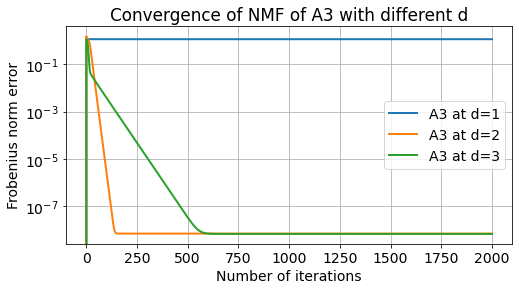

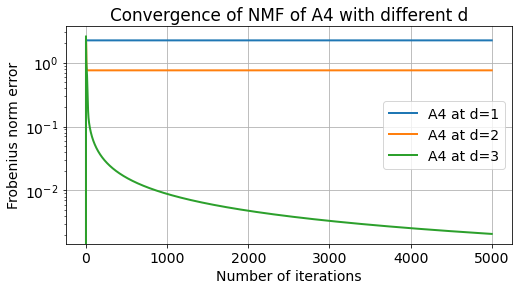

In [48]:
# 1g)
W1_A3, H2_A3, norm1_A3 = NMF(A3, 1, maxiter=2000)
W2_A3, H2_A3, norm2_A3 = NMF(A3, 2, maxiter=2000)
W3_A3, H3_A3, norm3_A3 = NMF(A3, 3, maxiter=2000)

plt.plot(norm1_A3, label = 'A3 at d=1')
plt.plot(norm2_A3, label = 'A3 at d=2')
plt.plot(norm3_A3, label = 'A3 at d=3')

plt.title('Convergence of NMF of A3 with different d')
plt.ylabel('Frobenius norm error')
plt.xlabel('Number of iterations')
plt.legend(loc = 5)
plt.yscale("log")
plt.show()

W1_A4, H2_A4, norm1_A4 = NMF(A4, 1, maxiter=5000)
W2_A4, H2_A4, norm2_A4 = NMF(A4, 2, maxiter=5000)
W3_A4, H3_A4, norm3_A4 = NMF(A4, 3, maxiter=5000)

plt.plot(norm1_A4, label = 'A4 at d=1')
plt.plot(norm2_A4, label = 'A4 at d=2')
plt.plot(norm3_A4, label = 'A4 at d=3')

plt.title('Convergence of NMF of A4 with different d')
plt.ylabel('Frobenius norm error')
plt.xlabel('Number of iterations')
plt.legend(loc = 5)
plt.yscale("log")
plt.show()

From the graphs we can see that equation 17 is satisfied and $\|A-W_{k+1}H_{k+1}\|_F \leq \|A-W_kH_k\|_F $ for both A3 and A4 for all the values of d. From the plot of A3 (rank 2) we can see that we get a lower difference (error) and a slower convergence the higher the d is. For example, with d = 1 we get a relatively big difference, but a much faster (fewer iterations) convergence to the NMF. The same applies to A4 (rank 3), but here the difference between d=2 and d=3 is much larger. This is to be expected as A4 i of rank 3 and therefore gets a better approximation with a full rank NMF. A3 is of rank 2 so a NMF of rank 3 should not add much accuracy.

<h2> Section 2: Applying the NMF to NFTs </h2>
We introduce the NFTs and do a NMF on them for d=64 and d=144, to observe what features get selected and how accurate the reconstruction is for different d. Lastly we will plot the accuracy of the NMF as a function of d.

We randomly select 500 images from a set of 10000 NFTs in a local folder named imgs and plot them using a handed out function.

In [18]:
def load_images(N):
    """
    Loads images from cryptopunk dataset. The loading order is deterministic,
    so for a certain N the exact same images will be loaded. 
    Input:
        N, integer, number of images to load
    Output:
        faces, (24,24,4,N) numpy array containing images
    """

    # Allocate array to store images
    faces = np.zeros((24,24,4,N))

    # Iteration variable
    i = 0

    # Iterate over folders
    for subdir, dirs, files in os.walk('./imgs'):

        # Iterate over files
        for file in files:

            # Filepath to load from
            filepath = subdir + os.sep + file

            # Make sure that the file is a .png
            if filepath[-3:] == 'png':

                # Load the image
                im = cv2.imread(filepath, cv2.IMREAD_UNCHANGED)

                # Convert it to RGBA and rescale pixels
                faces[:,:,:,i] = cv2.cvtColor(im, cv2.COLOR_BGRA2RGBA)/255.0

                i+=1
            if i == N:
                break
    return faces

# Number of faces to keep in final array
N = 500

# Load all 10000 images
faces = load_images(10000)

# Select N random images
choices = np.random.choice(faces.shape[-1],N, replace = False)
faces = faces[:,:,:,choices]

# Check that the shape is correct
print(faces.shape)


(24, 24, 4, 500)


In [19]:
# Code for plotting images
def plotimgs(imgs, nplot = 8, rescale = False, filename = None):
    """
    Plots nplot*nplot images on an nplot x nplot grid. 
    Saves to given filename if filename is given
    Can also rescale the RGB channels
    input:
        imgs: (24,24,4,N) or (24,24,3,N) array containing images, where N > nplot**2
        nplot: integer, nplot**2 images will be plotted
        rescale: bool
        filename: string, figure will be saved to this location. Should end with ".png".
    """
    # We will change some of the parameters of matplotlib, so we store the initial ones
    oldparams = plt.rcParams['figure.figsize']

    # New params to make better plot. There definitely exists better ways of doing this
    plt.rcParams['figure.figsize'] = (16, 16)

    # Initialize subplots
    fig, axes = plt.subplots(nplot,nplot)

    # Set background color
    plt.gcf().set_facecolor("lightgray")

    # Iterate over images
    for idx in range(nplot**2):
        
        # Indices
        i = idx//nplot; j = idx%nplot

        # Remove axis
        axes[i,j].axis('off')

        # Rescale RGB channels by dividing my maximal value
        if rescale:
            scaled_img = np.copy(imgs[:,:,:,idx])
            scaled_img[:,:,:3] = scaled_img[:,:,:3]/np.max(scaled_img[:,:,:3])
            axes[i,j].imshow(scaled_img)
        else:
            axes[i,j].imshow(imgs[:,:,:,idx])
    
    # Tight layout so images will appear closer together
    plt.tight_layout()

    # Save if filename is given
    if filename is not None:
        plt.savefig(filename)

    plt.show()

    # Return to old parameters
    plt.rcParams['figure.figsize'] = oldparams


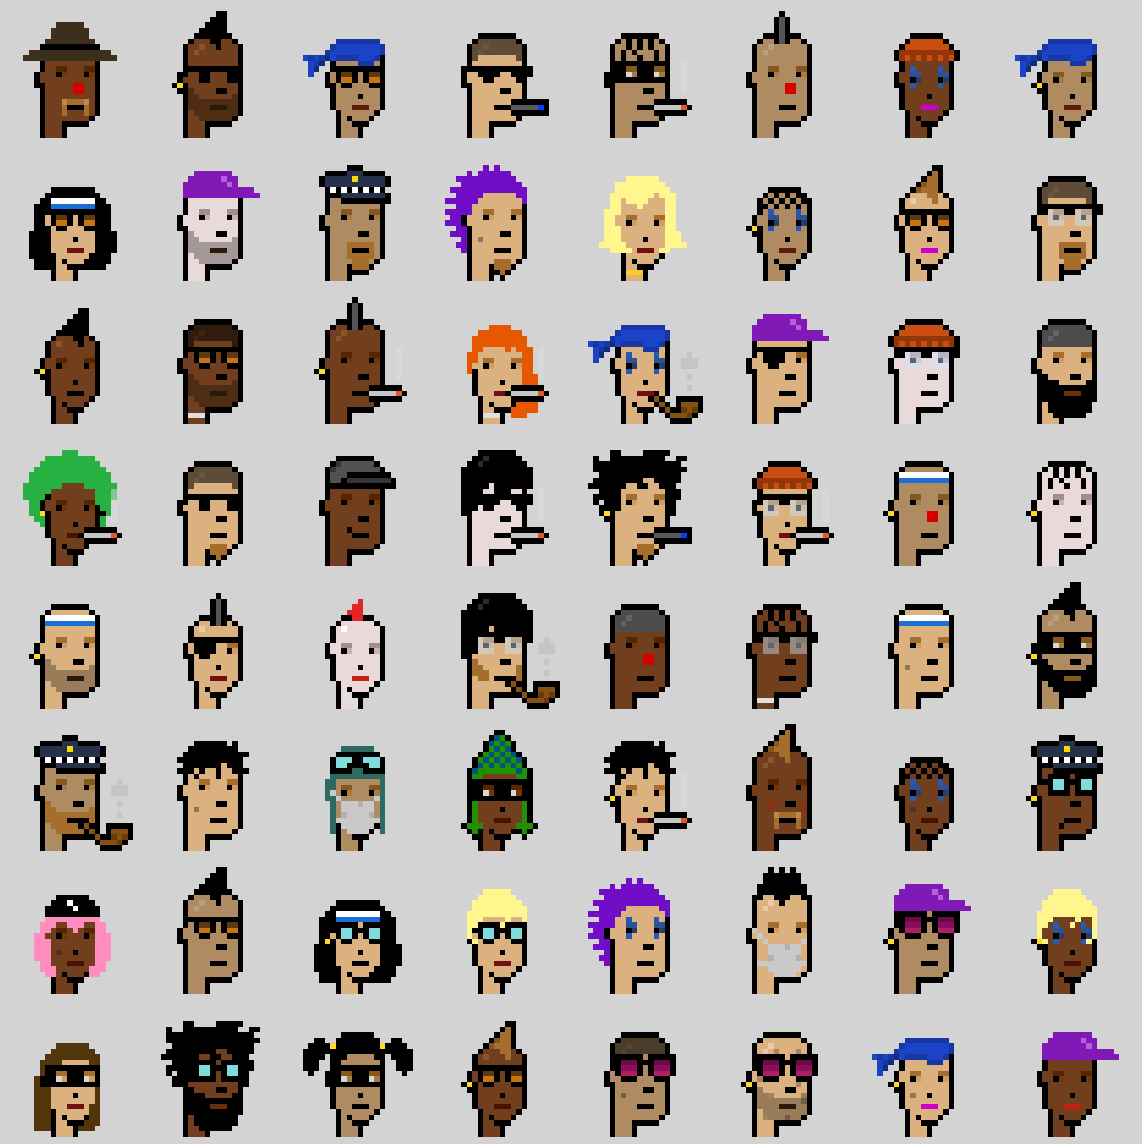

In [20]:
# Plotting the images we will be using for this project
# 2a)
plotimgs(faces, 8, filename="punks.png")

In [77]:
# Split the images into opacity and rgb channels
faces_opacity = faces[:,:,3,:]
faces_rgb = faces[:,:,:3,:]
shape = faces_rgb.shape

# Clever reshape "trick". This is the matrix we will apply the NMF to
faces_reshaped = faces_rgb.reshape(np.prod(shape)//N, N)

print(faces_reshaped.shape)

(1728, 500)


378


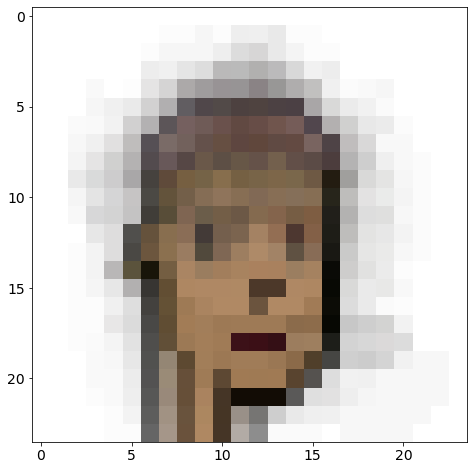

In [79]:
# 2b) Plotting an average of all NFTs
# We will change some of the parameters of matplotlib
newparams = {'figure.figsize': (8.0, 8.0), 'axes.grid': False}
plt.rcParams.update(newparams)

# New params to make better plot. There definitely exists better ways of doing this
plt.rcParams['figure.figsize'] = (8, 8)

imgs = np.mean(faces, axis=-1)
plt.imshow(imgs)

# Return to old parameters
newparams = {'figure.figsize': (8.0, 4.0), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
plt.rcParams.update(newparams)

rank = np.linalg.matrix_rank(faces_reshaped)
print(rank)

We see that the "average NFT" has a light tan skin color, that the general face of the shape is clear, and that the corners and most of the edges have zero opacity, which means that we can save a lot by setting those areas to zero. Through calculation we find that the rank of our reshaped faces matrix is 378, i.e. of our 500 NFTs about 378 of them are linearly independent and the other 122 faces can be represented by a linear combination of the others. This means that the full-rank NMF will have a d of 378 and this is the upper limit of our NMF in this case. This gives that we can save about a fourth of the space by using a full-rank NMF compared to storing the original images.

(1728, 64) 
 (64, 500)


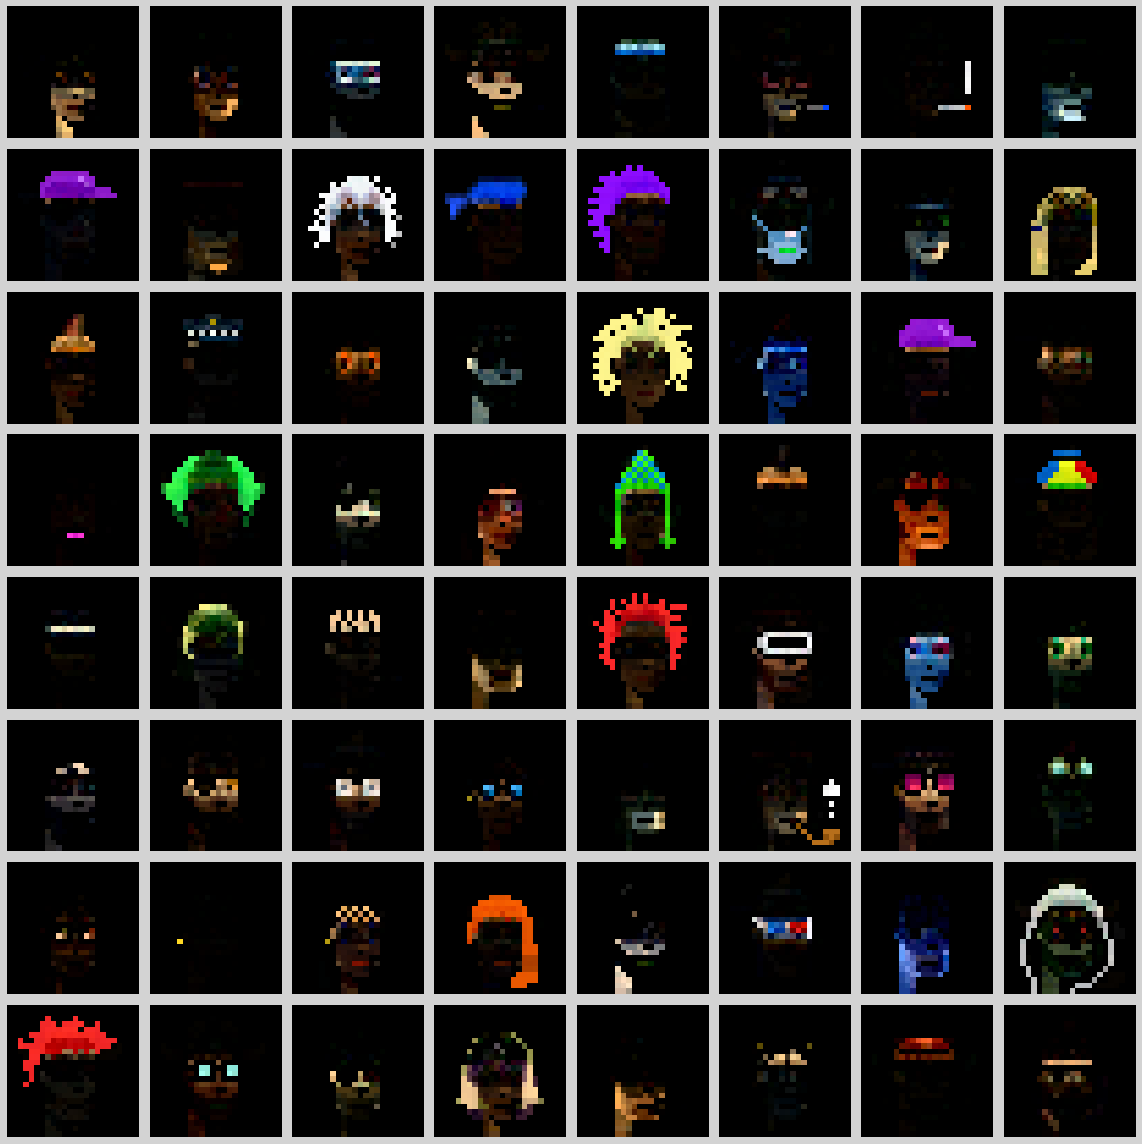

In [22]:
# 2c)
# NMF for d=64
# Also displaying the dimensions of W and H
dim = 8
W, H, _ = NMF(faces_reshaped, dim**2)
print(np.shape(W), '\n', np.shape(H))
NMF_rgb = W.reshape((24, 24, 3, dim**2))
plotimgs(NMF_rgb,dim, rescale=True)

(1728, 144) 
 (144, 500)


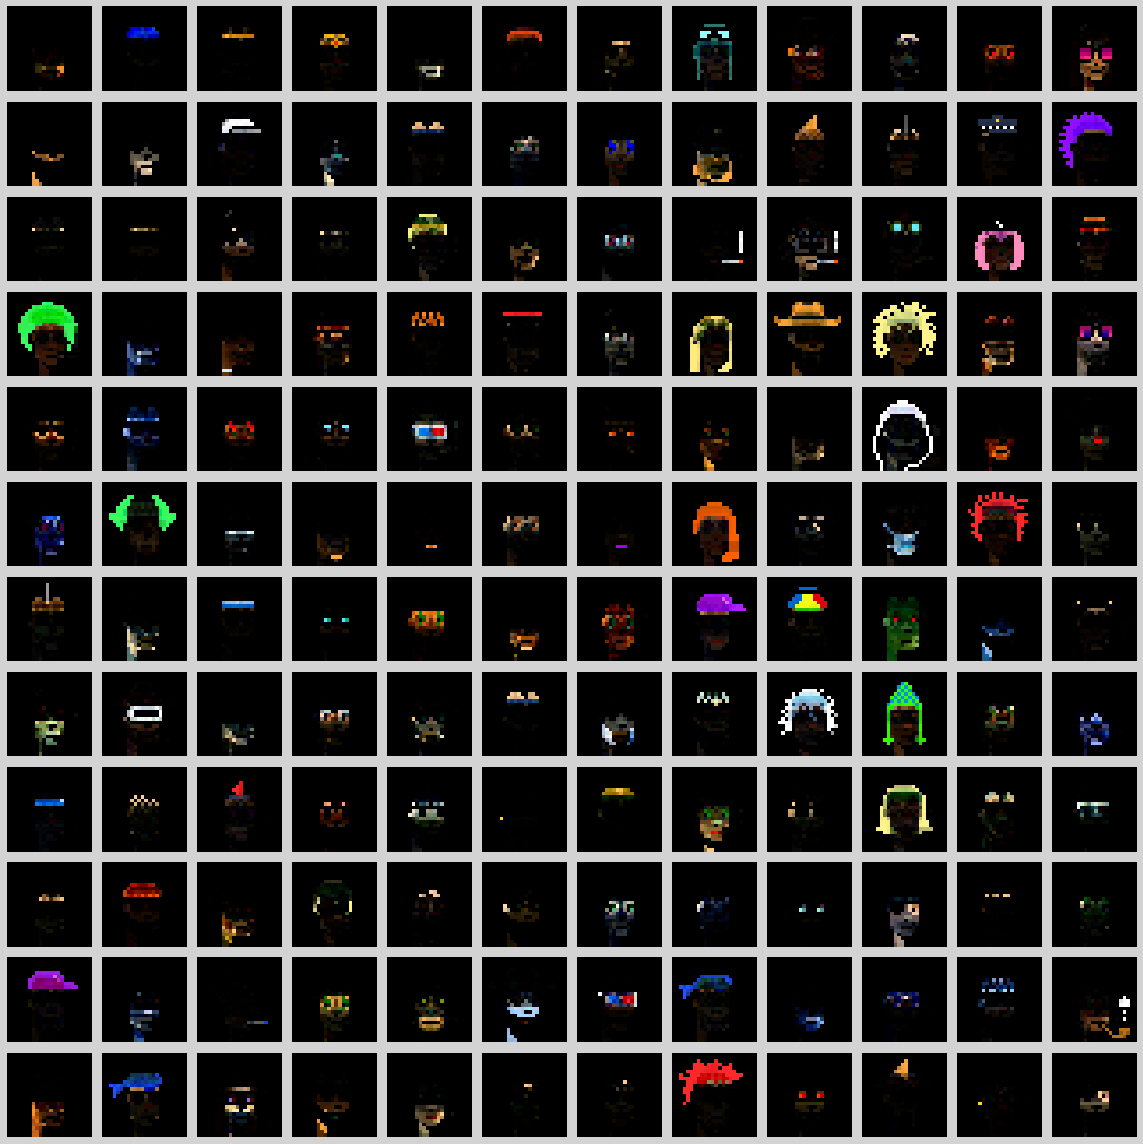

In [23]:
# NMF for d=144
dim12 = 12
W144, H144, _ = NMF(faces_reshaped, dim12**2)
print(np.shape(W144), '\n', np.shape(H144))
NMF_rgb144 = W144.reshape((24, 24, 3, dim12**2))
plotimgs(NMF_rgb144,dim12, rescale=True)

For d=64 we observe that the features are getting captured, with the most striking and shared features being the clearest. As one might expect the NMF also includes a compound of the faces to a certain degree. This comes from the fact that some faces are shared across features s.t. the faces are stored together with some of the features. This seems to happen to a large degree for the unique features especially, where if we have only one figure with a hat or hairstyle or strange glasses, their face is to a large degree combined with that feature. We also find some items that seem to only be the face for several of the more unique faces.
Repeating the experiment for d=144, we are able to separate a bit more of the faces from the features, and the features are overall clearer. It also seems like it chooses a few strange features to store, but that may be mostly just due to our human perspective. For example the NMF with d=144 creates several cigarettes (one with a face), which we may deem illogical, so this might be an example of the wasted processing power if the purpose of the images is viewing them without need for extreme detail, and also highlights a weaknesses of unsupervised machine learning.

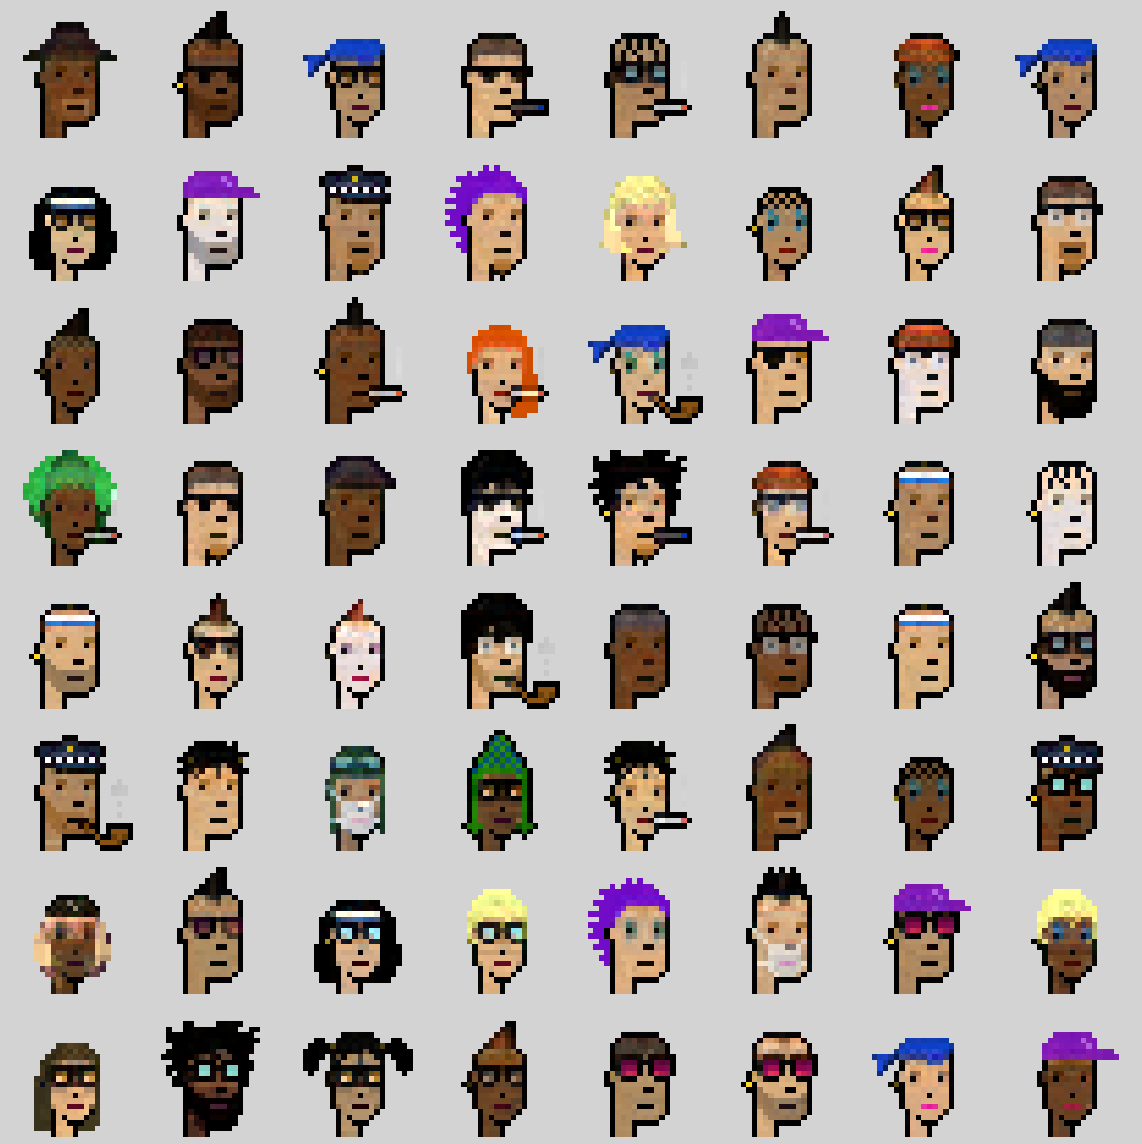

In [24]:
# 2d)
# Reconstruction for d=64
reconstruct = np.zeros(faces.shape)
reconstruct[:,:,:3,:] = (W@H).reshape(faces_rgb.shape)
for coord in np.argwhere(reconstruct>1):
    reconstruct[coord[0], coord[1], coord[2], coord[3]]=1
reconstruct[:,:,3,:] = faces_opacity
plotimgs(reconstruct, 8)

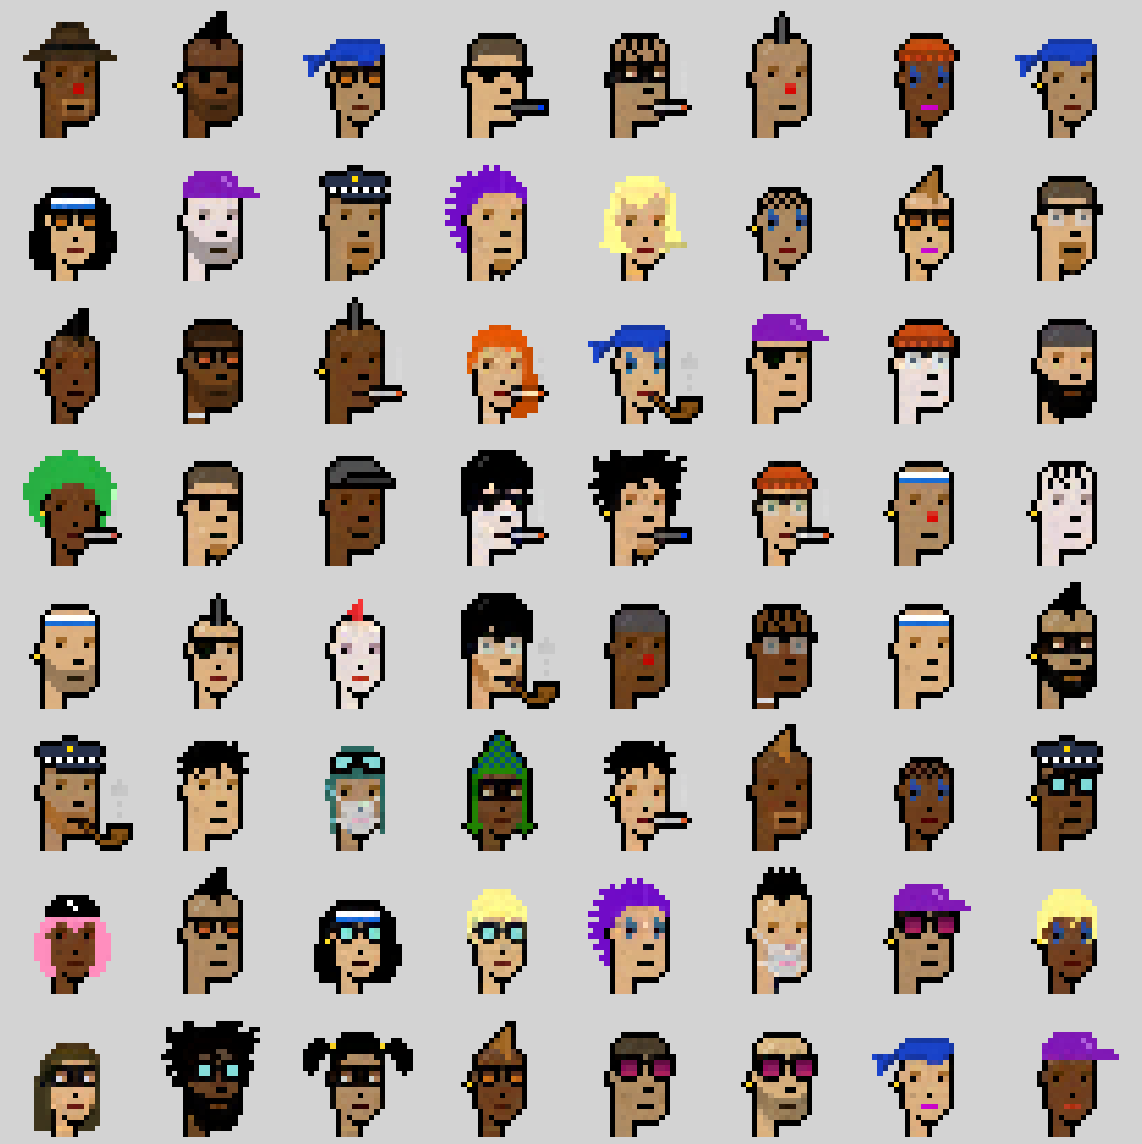

In [25]:
# Reconstruction for d=144
reconstruct144 = np.zeros(faces.shape)
reconstruct144[:,:,:3,:] = (W144@H144).reshape(faces_rgb.shape)
for coord in np.argwhere(reconstruct144>1):
    reconstruct144[coord[0], coord[1], coord[2], coord[3]]=1
reconstruct144[:,:,3,:] = faces_opacity
plotimgs(reconstruct144, 8)

Here we have the images reconstructed from the NMF factorization (d=64 and d=144) with back-added opacity. We notice that the most striking features of the NFTs are quite clear, which implies the NMF captured them well. Notice especially the face masks, hairstyles, hats, glasses, cigarettes, and the piercing. The NMF seems to have difficulties with most beards (except the black ones) as the beard styles are often slightly pixelated. This seems to be general for light hair colors and dark skin. Notice the man and woman with dark skin and a light pointy hairstyle and especially the woman with dark skin and pink hair. In these three figures the color from the hair seems to mix with the face. Otherwise the skin color is usually quite good, but the faces are still, in some cases, very pixelated. To sum up it seems like the NMF works quite well with d=64, but it seems to struggle with the skin in the face and the mouth area.

We have also tried this reconstruction with d=144 and the images were much clearer, the beard styles seem to have gotten captured at a good level of detail and the faces are much clearer. Here we have one NFT with a  frown and one with a smirk, these were barely visible at d=144. The hats are usually especially clear. Whether the increase in computational time and data was worth it, however, is unclear, as the reconstruction with d=64 was already pretty good, and we had to double the detail and rows in the NMF, which also quadruples the flops needed to calculate the reconstruction, i.e. the matrix multiplication. In our opinion a reconstruction below d=144 would have been sufficient for the simple NFTs, as the required processing power and -time increases rapidly and the level of detail only slowly improves.

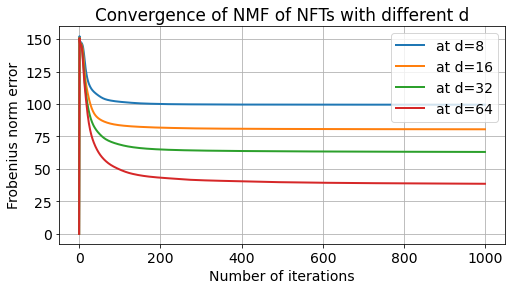

In [67]:
# 2e)

W8, H8, diff8 = NMF(faces_reshaped, 8)
W16, H16, diff16 = NMF(faces_reshaped, 16)
W32, H32, diff32 = NMF(faces_reshaped, 32)
W64, H64, diff64 = NMF(faces_reshaped, 64)

plt.plot(diff8, label = 'at d=8')
plt.plot(diff16, label = 'at d=16')
plt.plot(diff32, label = 'at d=32')
plt.plot(diff64, label = 'at d=64')


plt.title('Convergence of NMF of NFTs with different d')
plt.ylabel('Frobenius norm error')
plt.xlabel('Number of iterations')
plt.legend(loc = 1)
plt.show()

Here we plotted the convergence of the NMF as a function of iterations with different d. We see as before that time to convergence is slower for larger d, and that the accuracy seems to increase linearly with a doubling of d, this is however a gross oversimplification as we only have four data points here. It seems like we have reached convergence for all d. As we have a $1728\times500$ matrix and the Frobenius norm sums the absolute value of the error at each cell. It fits with how accurate the NMF is for d=64, and is a testiment to the efficiency of NMF.

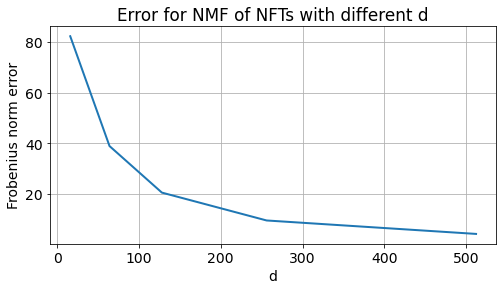

In [63]:
# 2f)

d_list = [16, 64, 128, 256, 512]
error_list = []
for dimension in d_list:
    _, _, error = NMF(faces_reshaped, dimension)
    error_list.append(error[-1])

plt.plot(d_list, error_list)
plt.title('Error for NMF of NFTs with different d')
plt.ylabel('Frobenius norm error')
plt.xlabel('d')
plt.show()

Here we see that the error of the NMF seems to decrease asymptotically as d increases. This fits with our expectations as we would expect the NMF to get better with increasing rank and hope it eventually converges as the "faces" matrix is non-negative. We would expect the benefit of increasing d to decrease as d gets larger as d "represents" the number of features stored and as we add more and more large/common features, the further increase in accuracy by adding one feature in the NMF should decrease fast as we only can slightly improve upon the existing extrapolations.

<h2> Section 3: Denoising using the NMF </h2>
We now add noise to the NFTs and experiment with noise reduction using NMF.

In [28]:
def add_noise(imgs_reshaped, sigma = 0.1):
    """
    Adds gaussian noise to images as described in text.
    Note that imgs must be given as a (24*24*3, N) numpy array, i.e the reshaped images
    Input:
        imgs_reshaped: (1728,N) numpy array
        sigma: scalar, noise level
    Output:
        noisy_faces: (1728,N) numpy array containing noisy images
    """
    # Noise level
    sigma = 0.1

    # Array that will store the rgb channels of the noisy images
    noisy_faces = np.copy(imgs_reshaped)

    # Number of noisy values we need
    nnzero = faces_reshaped[np.nonzero(imgs_reshaped)].shape[0]

    # Sample noisy values and add noise
    noise = np.random.normal(0.0,1,nnzero)
    noisy_faces[np.nonzero(imgs_reshaped)] += sigma*noise

    # Clip to lie between 0 and 1 so that we can still interpret them as images
    noisy_faces = np.maximum(0.0,np.minimum(1.0, noisy_faces))

    return noisy_faces

Vi kan nå legge til støy til bildene våre, legge på opasitetskanalaen igjen og plotte. Dere må gjøre noe lignende etter dere har anvendt NMF og ønsker å plotte rekonstruksjoner med opasitet.

41.78874735612576


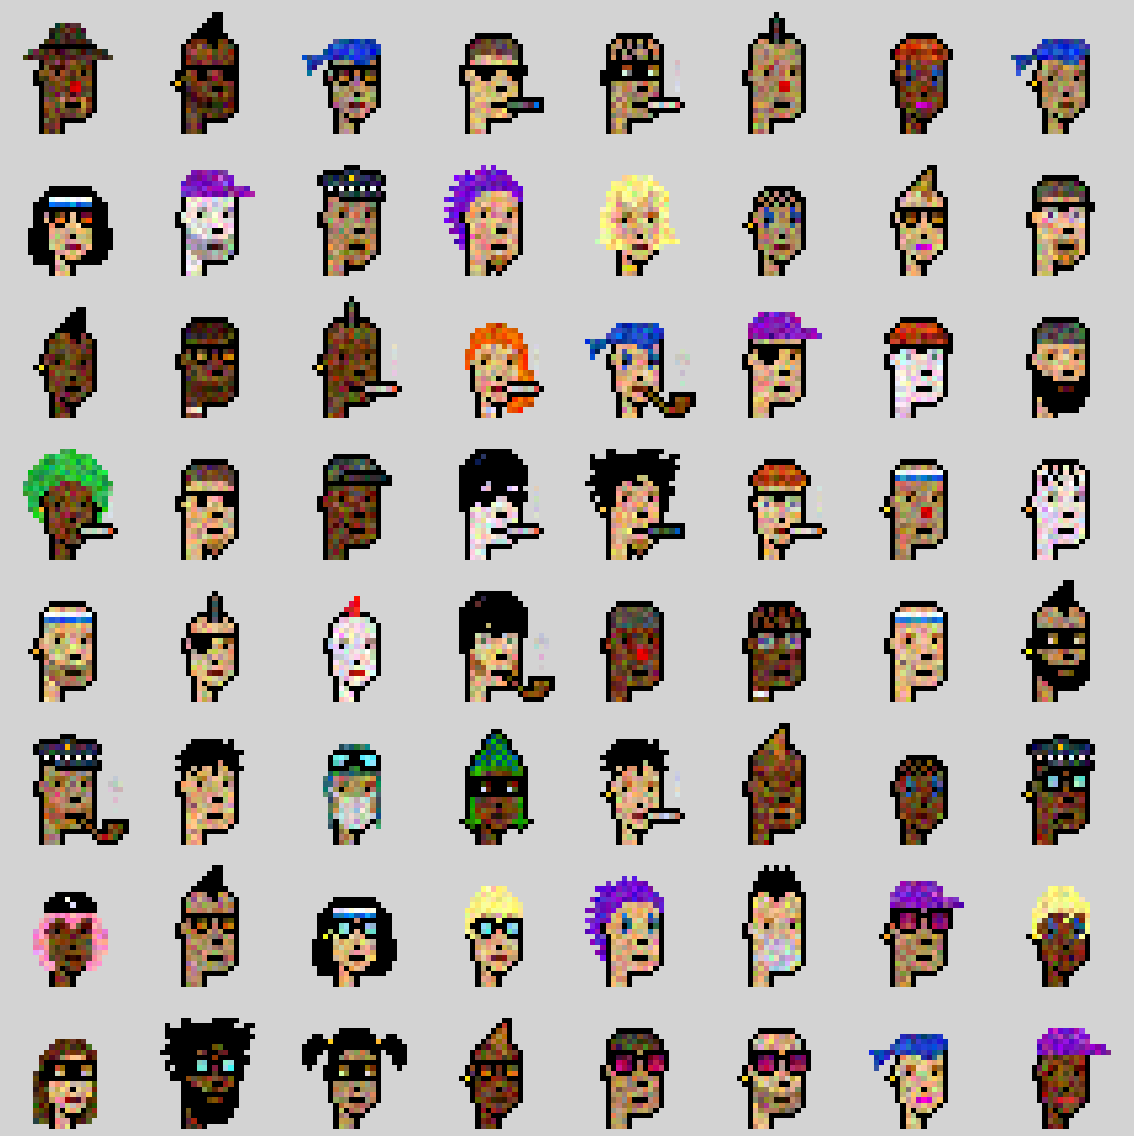

In [68]:
# 3a)
noisy_faces = add_noise(faces_reshaped)

# Calculate the error of the noisy images
noise_residual = np.linalg.norm(noisy_faces - faces_reshaped, 'fro')
print(noise_residual)

# For plotting noisy images we add the opacity
noisy_faces_with_opacity = np.zeros(faces.shape)
noisy_faces_with_opacity[:,:,:3,:] = noisy_faces.reshape(faces_rgb.shape)
noisy_faces_with_opacity[:,:,3,:] = faces_opacity
plotimgs(noisy_faces_with_opacity)

Now we have added noise to the original NFTs and get that $\|A_{noisy}-A\|_F=41.79$, which is comparable to the error we got for d=64 in the last section. The NMF for d=64 however, looks much better to the human eye, with the exception of the dark skinned woman wth pink hair, where we get very similar quality, interestingly enough. In general the darker skin tones seem to get more noisy, however the model should add equal amounts of noise independent of the color (the opacity channel is noise free), but the darker colors get clipped. This has the effect that black has no noise and we would expect brown to also be less noisy. This is more an interesting side note than anything else as it should not affect the calculations and rather reflects on how we perceive color.

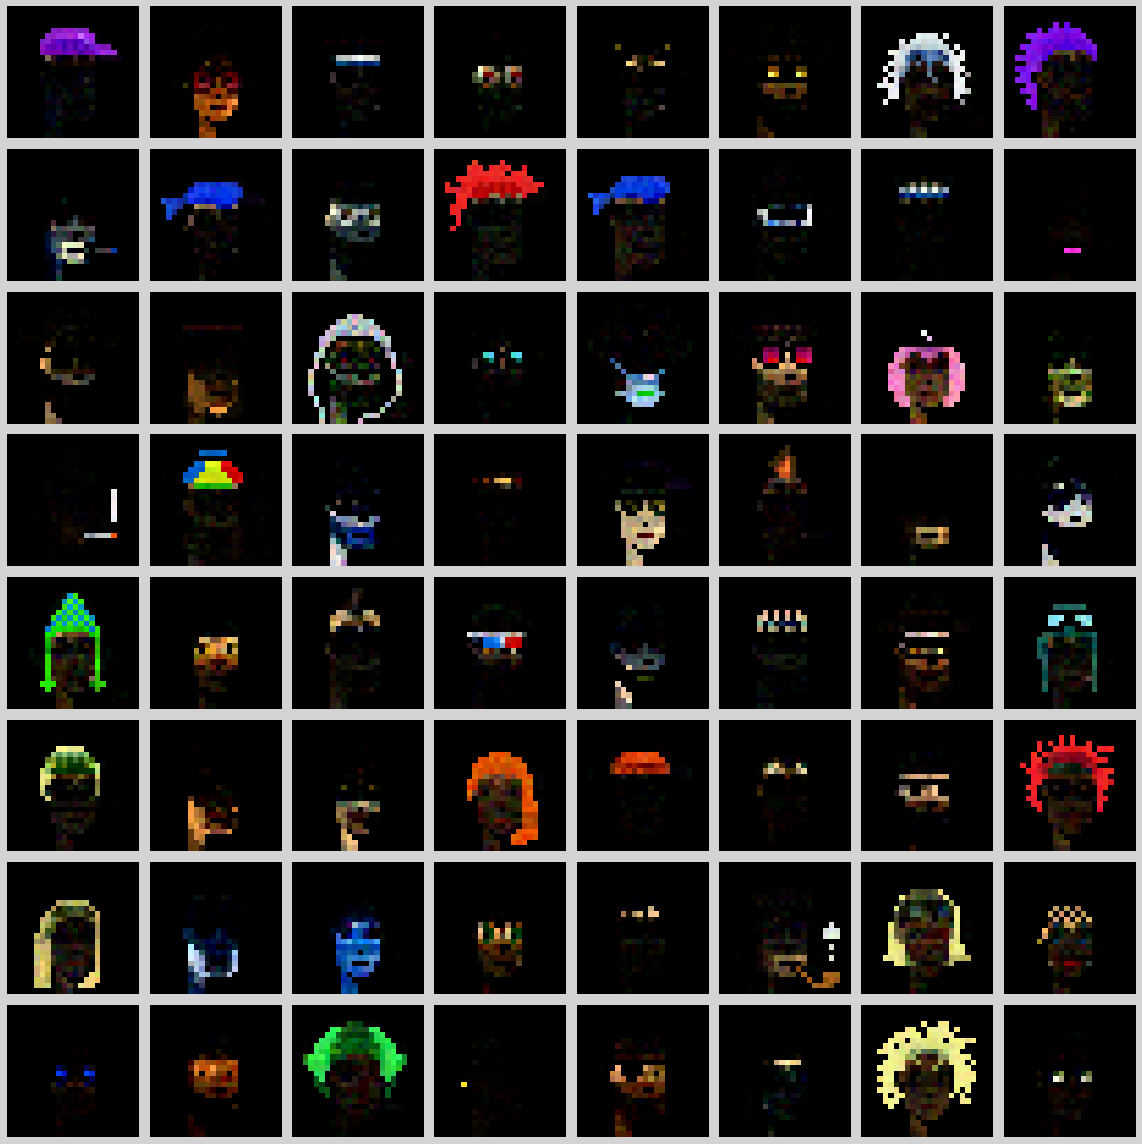

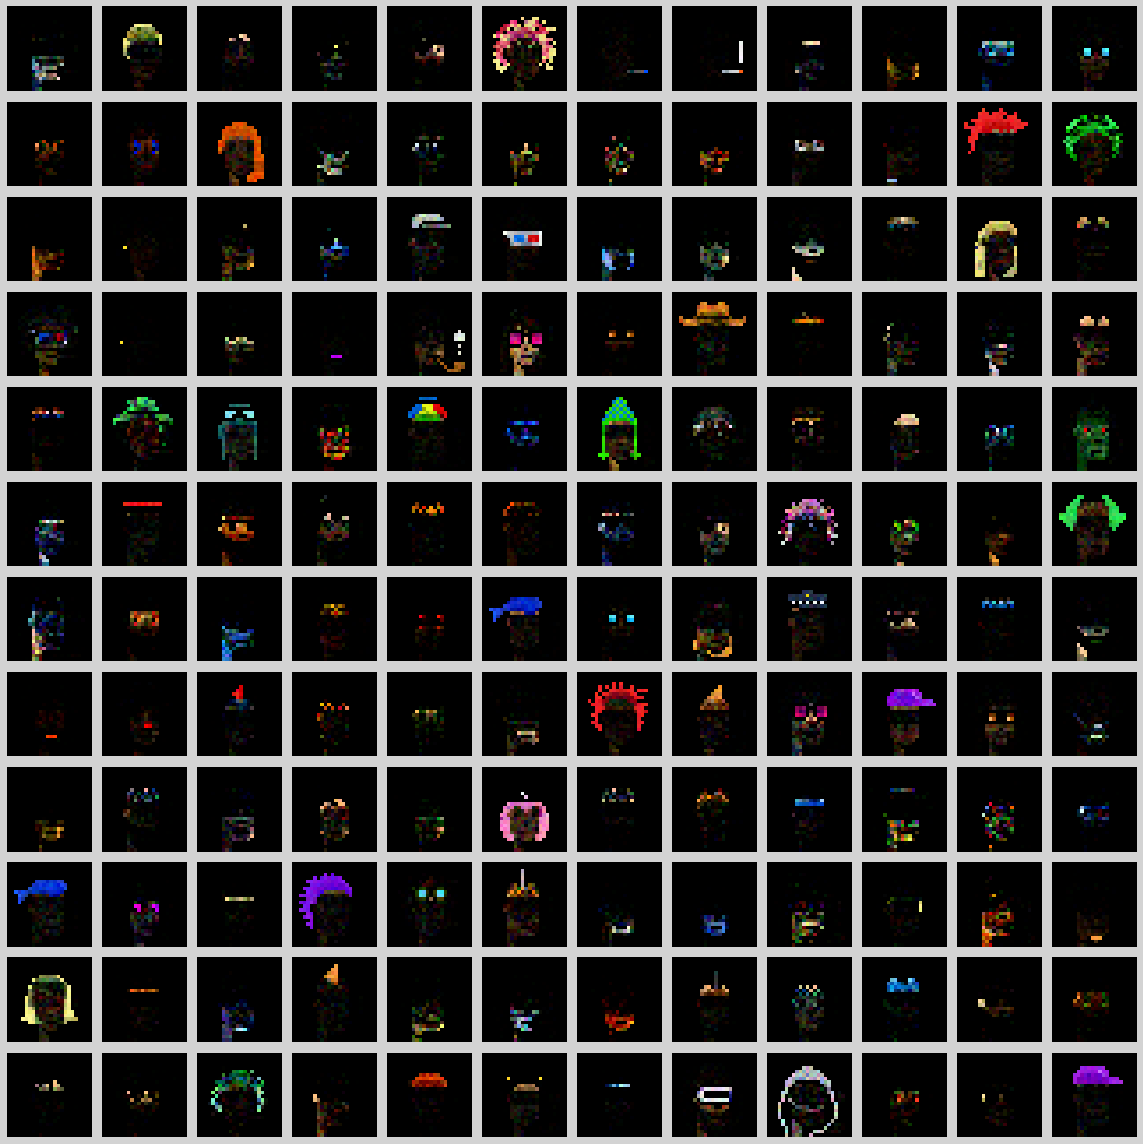

In [30]:
# 3b same as 2c but for noisy_faces instead
# NMF for d=64
dim_3 = 8
W_noisy, H_noisy, _ = NMF(noisy_faces, dim_3**2)
NMF_noisy_rgb = W_noisy.reshape((24, 24, 3, dim_3**2))
plotimgs(NMF_noisy_rgb,dim_3, rescale=True)

#for d=144:
dim_3_12 = 12
W144_noisy, H144_noisy, _ = NMF(noisy_faces, dim_3_12**2)
NMF_noisy_rgb144 = W144_noisy.reshape((24, 24, 3, dim_3_12**2))
plotimgs(NMF_noisy_rgb144,dim_3_12, rescale=True)

The columns of W include some of the noise, but this does not necessarily mean that the reconstructions will be poor, as we will see. Interestingly enough W for d=144 seems to have several faces that solely consist of noise, but as the plot is rescaled it may just be a side effect of this, while the original features would be fairly similar to those in section 2. In general the columns seem fairly noisy compared to those of section 2, but the columns alone have seemingly reduced some of the noisy set.

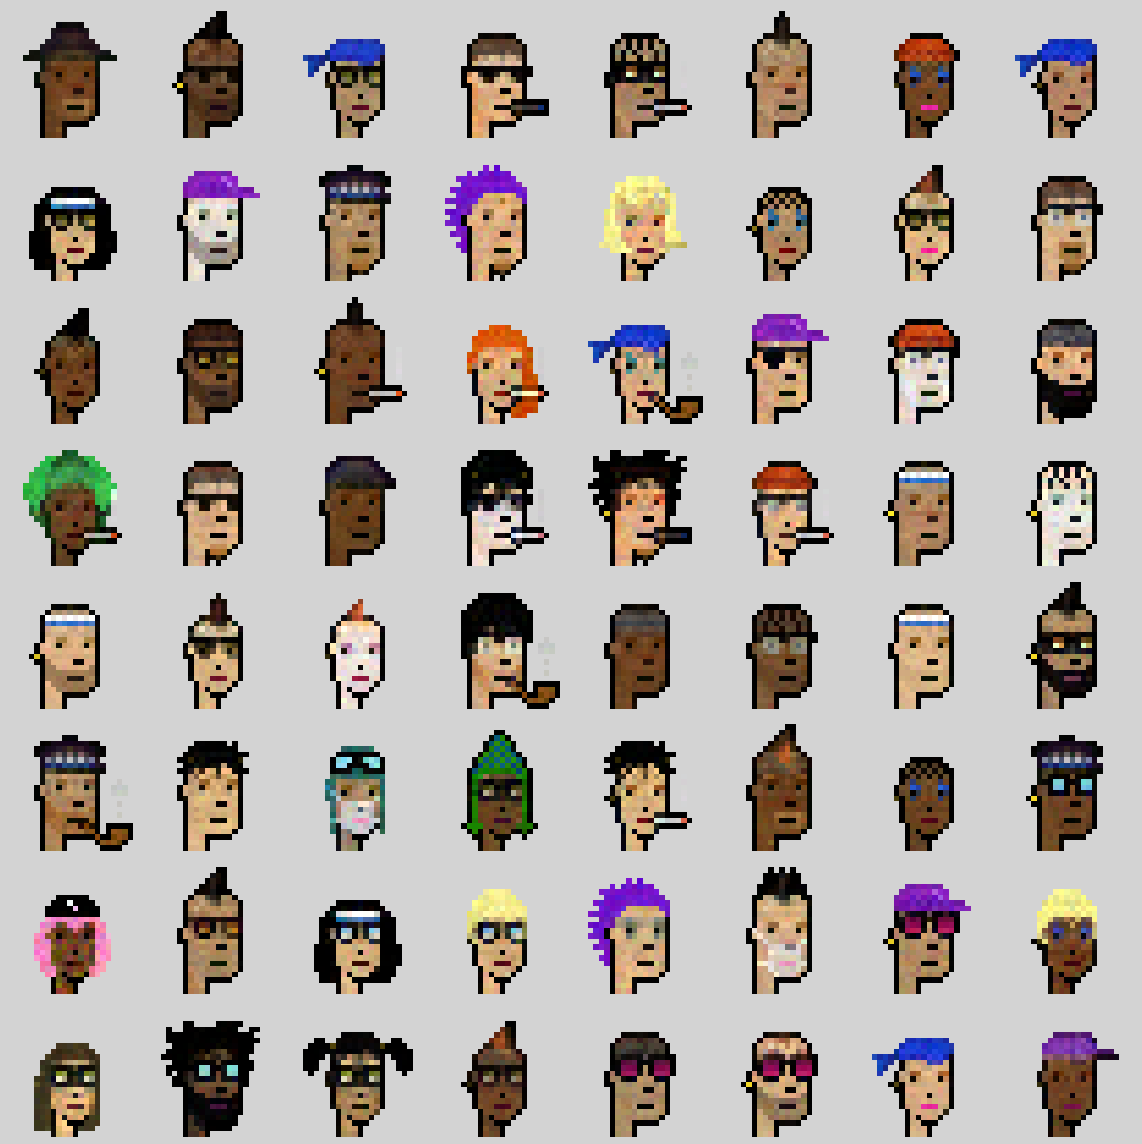

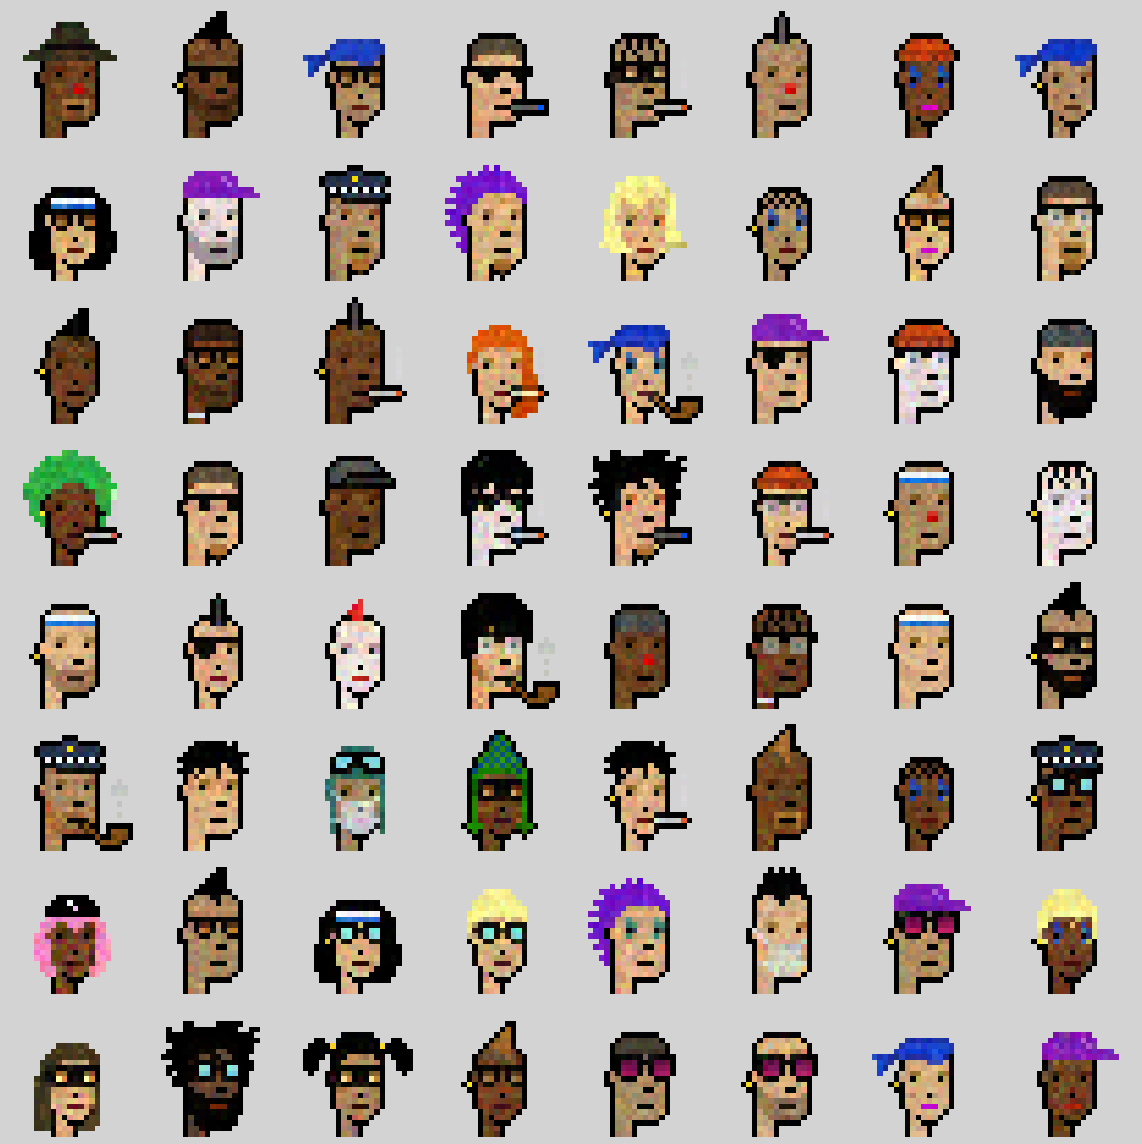

In [31]:
# Reconstruction for d=64
reconstruct_noisy = np.zeros(faces.shape)
reconstruct_noisy[:,:,:3,:] = (W_noisy@H_noisy).reshape(faces_rgb.shape)
for coord in np.argwhere(reconstruct_noisy>1):
    reconstruct_noisy[coord[0], coord[1], coord[2], coord[3]]=1
reconstruct_noisy[:,:,3,:] = faces_opacity
plotimgs(reconstruct_noisy, 8)

# Reconstruction for d=144
reconstruct_noisy144 = np.zeros(faces.shape)
reconstruct_noisy144[:,:,:3,:] = (W144_noisy@H144_noisy).reshape(faces_rgb.shape)
for coord in np.argwhere(reconstruct_noisy144>1):
    reconstruct_noisy144[coord[0], coord[1], coord[2], coord[3]]=1
reconstruct_noisy144[:,:,3,:] = faces_opacity
plotimgs(reconstruct_noisy144, 8)

The reconstructions have been very efficiently denoised, but are of some lower quality as the ones in the last section. As noted in the plot of the noisy NFTs, the dark faces seem to be more affected by the noise, but the reconstructions (especially for d=144) in general have clear and detailed features, and the problem area seems to be the face. This shows that we probably notice the faces more, as there seem to be a greater amount of unique features than unique faces, which is natural as we are social beings. With added noise the woman with pink hair that we have mentioned earlier is very poorly resolved even with d=144.

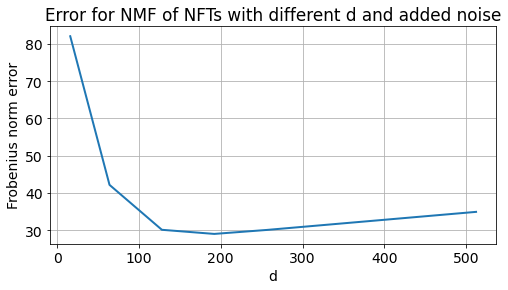

In [69]:
# 3c)

d_list = [16, 64, 128, 192, 256, 512]
error_list = []
for dimension in d_list:
    W_3c, H_3c, _ = NMF(noisy_faces, dimension)
    error_list.append(np.linalg.norm(faces_reshaped-W_3c@H_3c,'fro'))

plt.plot(d_list, error_list)
plt.title('Error for NMF of NFTs with different d and added noise')
plt.ylabel('Frobenius norm error')
plt.xlabel('d')
plt.show()


Here we see that the NMF gets more accurate, like before until about d=200. After that it seems to level off and thereafter slowly increase. At each point (as one might expect) the error is larger if we use NMF on the noisy set than if we apply it to the original set. Not only is the error larger, but the rate of improval as we increase d is slower than for the original set of NFTs. This makes sense if we think of the NMF as extracting common features from the dataset. If we add noise, every feature has added noise and we might not be able to create a perfect reconstruction since we are not guaranteed that we have enough features where a certain pixel is correct. As the noise level increases the number of such pixels where we cannot find the right value increases.
But this does not explain the accuracy decreasing again as we increase d to above 200. When the NMF extracts common features it tries to give each individual NFT a value describing how much of each feature it has. This is called fitting, and when we have too few columns in W (d) and we cannot represent every feature we have what is called underfitting. Now, if we add noise to the NFTs we will add a unique feature to each NFT, every NFT gets its own feature that is its own random noise. When we pump up the columns of W too high (above 200), we might (as mentioned earlier) have the NMF algorithm interpret the noise as a feature to be included. This is what is called overfitting and explains the decrease in accuracy as we add too many columns to W.

To sum up the NMF now increases in accuracy with d slower than before becuase the noise adds the number of operations required to extrapolate from the data, while overfitting makes the accuracy decrease after a certain point. Both of these phenomenon make the accuracy level off earlier i.e. at a higher level (at d=128 the error is at ~30 with noise and at ~20 without).

<h2> Conclusion </h2>
We find that NMFs are a surprisingly efficient tool for compressing image data and extracting common features from a set of similar images. We found that NMFs quickly improve in accuracy (in our case) by only adding few extra layers of detail (d). Data sets such as NFTs are especially well suited to NMF as they have a lot of features that are identical between images. One advantage is as mentioned the limited storage requirement and the accurate representation of data with little information. Even though the full rank NMF would have a d of 378, we got very good results with only d = 144, about half of the full rank. The results for a d as low as 64 were also acceptable, and much less demanding on processing time/power. This leads us to a drawback in using NMF, as matrix multiplication is a resource intensive task, so it might be more practical to simply increase the storage available if the data sets are not huge and/or as modular as NFTs are. NMF is as demonstrated a very useful tool in denoising, abstracting random noise away from data. We were surprised to see how well the denoising worked, especially with d=64, as the noise seemed to reduce the benefit of increasing d, which also was a result of a general reduction in accuracy from added noise.

Denoising is where the NMF shone in this project, as we not only reduced the storage space necessary for our data set, but also managed to remove a large part of the error.  A problem with using NMFs for denoising however, is the possibility of overfitting, so there is an upper limit for how efficient we can get. Still, it was indeed surprising to find that the power of the NMF is almost paradoxical; adding accuracy by removing information.